In [3]:
# Install required packages
!pip install pandas numpy matplotlib seaborn plotly scipy scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from scipy import stats
import os

In [4]:
# Set style and suppress warnings
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Environment setup complete!")

✅ Environment setup complete!


DATA LOADING

In [5]:
# Load datasets
print("📊 Loading datasets...")

# Load Fear & Greed Index data
try:
    # Update this path based on your Google Drive structure
    sentiment_path = "/content/fear_greed_index.csv"  # Adjust path as needed
    sentiment_df = pd.read_csv(sentiment_path)
    print(f"✅ Sentiment data loaded: {sentiment_df.shape}")
except Exception as e:
    print(f"❌ Error loading sentiment data: {e}")
    # Create sample data structure for demonstration
    sentiment_df = pd.DataFrame({
        'Date': pd.date_range('2023-01-01', periods=365, freq='D'),
        'Classification': np.random.choice(['Fear', 'Greed'], 365)
    })
    print("📝 Using sample sentiment data for demonstration")

# Load Hyperliquid trader data
try:
    trader_path = "/content/historical_data.csv"  # Adjust path as needed
    trader_df = pd.read_csv(trader_path)
    print(f"✅ Trader data loaded: {trader_df.shape}")
except Exception as e:
    print(f"❌ Error loading trader data: {e}")
    # Create sample data structure for demonstration
    np.random.seed(42)
    n_records = 10000
    trader_df = pd.DataFrame({
        'account': [f'trader_{i//100}' for i in range(n_records)],
        'symbol': np.random.choice(['BTC-USD'], n_records),
        'execution_price': np.random.normal(45000, 5000, n_records),
        'size': np.random.lognormal(0, 1, n_records),
        'side': np.random.choice(['buy', 'sell'], n_records),
        'time': pd.date_range('2023-01-01', periods=n_records, freq='1H'),
        'start_position': np.random.uniform(-10, 10, n_records),
        'event': np.random.choice(['open', 'close'], n_records),
        'closedPnL': np.random.normal(0, 100, n_records),
        'leverage': np.random.uniform(1, 10, n_records)
    })
    print("📝 Using sample trader data for demonstration")

print("\n" + "="*50)
print("DATA LOADING SUMMARY")
print("="*50)
print(f"Sentiment data: {sentiment_df.shape[0]:,} rows, {sentiment_df.shape[1]} columns")
print(f"Trader data: {trader_df.shape[0]:,} rows, {trader_df.shape[1]} columns")

📊 Loading datasets...
✅ Sentiment data loaded: (2644, 4)
✅ Trader data loaded: (211224, 16)

DATA LOADING SUMMARY
Sentiment data: 2,644 rows, 4 columns
Trader data: 211,224 rows, 16 columns


DATA INSPECTION

In [7]:
print("\n📋 SENTIMENT DATA INSPECTION")
print("-" * 30)
print(f"Data types:\n{sentiment_df.dtypes}")
print(f"\nFirst few rows:")
print(sentiment_df.head())
print(f"\nUnique classifications: {sentiment_df['classification'].unique()}")
print(f"Classification distribution:\n{sentiment_df['classification'].value_counts()}")

print("\n📋 TRADER DATA INSPECTION")
print("-" * 30)
print(f"Data types:\n{trader_df.dtypes}")
print(f"\nFirst few rows:")
print(trader_df.head())
print(f"\nColumns: {list(trader_df.columns)}")

# Check for missing values
print("\n🔍 MISSING VALUES ANALYSIS")
print("-" * 30)
print("Sentiment data missing values:")
print(sentiment_df.isnull().sum())
print("\nTrader data missing values:")
print(trader_df.isnull().sum())


📋 SENTIMENT DATA INSPECTION
------------------------------
Data types:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

First few rows:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Unique classifications: ['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']
Classification distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

📋 TRADER DATA INSPECTION
------------------------------
Data types:
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST 

DATA PREPROCESSING

In [19]:
print("\n🔧 DATA PREPROCESSING")
print("-" * 30)

# Convert date columns to datetime
print("Converting date columns...")
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
# Convert 'Timestamp IST' in trader_df to datetime
# Infer the format automatically
try:
    trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp IST'], infer_datetime_format=True)
except Exception as e:
    print(f"❌ Error converting 'Timestamp IST': {e}")
    print("Attempting with a specific format 'dd-mm-yyyy HH:MM'...")
    try:
        trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
    except Exception as e:
        print(f"❌ Error converting with specific format: {e}")
        print("Please check the format of 'Timestamp IST' column.")
        # As a fallback, create a dummy date column to avoid errors in subsequent steps
        trader_df['Timestamp'] = pd.to_datetime('1970-01-01')


# Extract date from trader timestamp for merging
trader_df['date'] = trader_df['Timestamp'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])


# Sort data by date
sentiment_df = sentiment_df.sort_values('date').reset_index(drop=True)
trader_df = trader_df.sort_values('Timestamp').reset_index(drop=True)

print(f"✅ Date range - Sentiment: {sentiment_df['date'].min()} to {sentiment_df['date'].max()}")
print(f"✅ Date range - Trader: {trader_df['date'].min()} to {trader_df['date'].max()}")


# Create additional features
print("\n🔨 FEATURE ENGINEERING")
print("-" * 30)

# Add time-based features to trader data
trader_df['hour'] = trader_df['Timestamp'].dt.hour
trader_df['day_of_week'] = trader_df['Timestamp'].dt.dayofweek
trader_df['month'] = trader_df['Timestamp'].dt.month

# Calculate position value using Size USD
trader_df['position_value'] = trader_df['Size USD']

# Create profit/loss categories
trader_df['pnl_category'] = pd.cut(trader_df['Closed PnL'],
                                  bins=[-np.inf, -100, 0, 100, np.inf],
                                  labels=['Large Loss', 'Small Loss', 'Small Profit', 'Large Profit'])


print("✅ Feature engineering complete")
print("\nUpdated Trader data with new features:")
display(trader_df.head())


🔧 DATA PREPROCESSING
------------------------------
Converting date columns...
❌ Error converting 'Timestamp IST': time data "28-12-2023 06:52" doesn't match format "%m-%d-%Y %H:%M", at position 3. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Attempting with a specific format 'dd-mm-yyyy HH:MM'...
✅ Date range - Sentiment: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
✅ Date range - Trader: 2023-05-01 00:00:00 to 2025-05-01 00:00:00

🔨 FEATURE ENGINEERING
------------------------------
✅ Feature engineering complete

Updated Trader data with new features:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,hour,day_of_week,month,position_value,pnl_category
0,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1898.6000,0.0722,137.0800,BUY,01-05-2023 01:06,0.1791,Open Long,0.0000,0x875d3e1af52b5b758e4f04015b774e0111006a118601...,173271100,True,0.0000,0.0000,2023-05-01 01:06:00,2023-05-01,1,0,5,137.0800,Small Loss
1,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9000,0.0824,156.3900,BUY,01-05-2023 01:06,0.0967,Open Long,0.0000,0x875d3e1af52b5b758e4f04015b774e0111006a118601...,173271100,True,0.0000,0.0000,2023-05-01 01:06:00,2023-05-01,1,0,5,156.3900,Small Loss
2,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9000,0.0967,183.5300,BUY,01-05-2023 01:06,0.0000,Open Long,0.0000,0x875d3e1af52b5b758e4f04015b774e0111006a118601...,173271100,True,0.0000,0.0000,2023-05-01 01:06:00,2023-05-01,1,0,5,183.5300,Small Loss
3,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1000,0.4933,1100.1100,BUY,05-12-2023 03:11,0.0000,Open Long,0.0000,0x02721e3c6061bddfdc1204065f9dfe0138003649ef8c...,4064960965,True,0.2750,632000000000000.0000,2023-12-05 03:11:00,2023-12-05,3,1,12,1100.1100,Small Loss
4,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1000,0.8681,1935.9500,BUY,05-12-2023 03:11,0.4933,Open Long,0.0000,0x02721e3c6061bddfdc1204065f9dfe0138003649ef8c...,4064960965,True,0.4840,234000000000000.0000,2023-12-05 03:11:00,2023-12-05,3,1,12,1935.9500,Small Loss



📊 EXPLORATORY DATA ANALYSIS
------------------------------


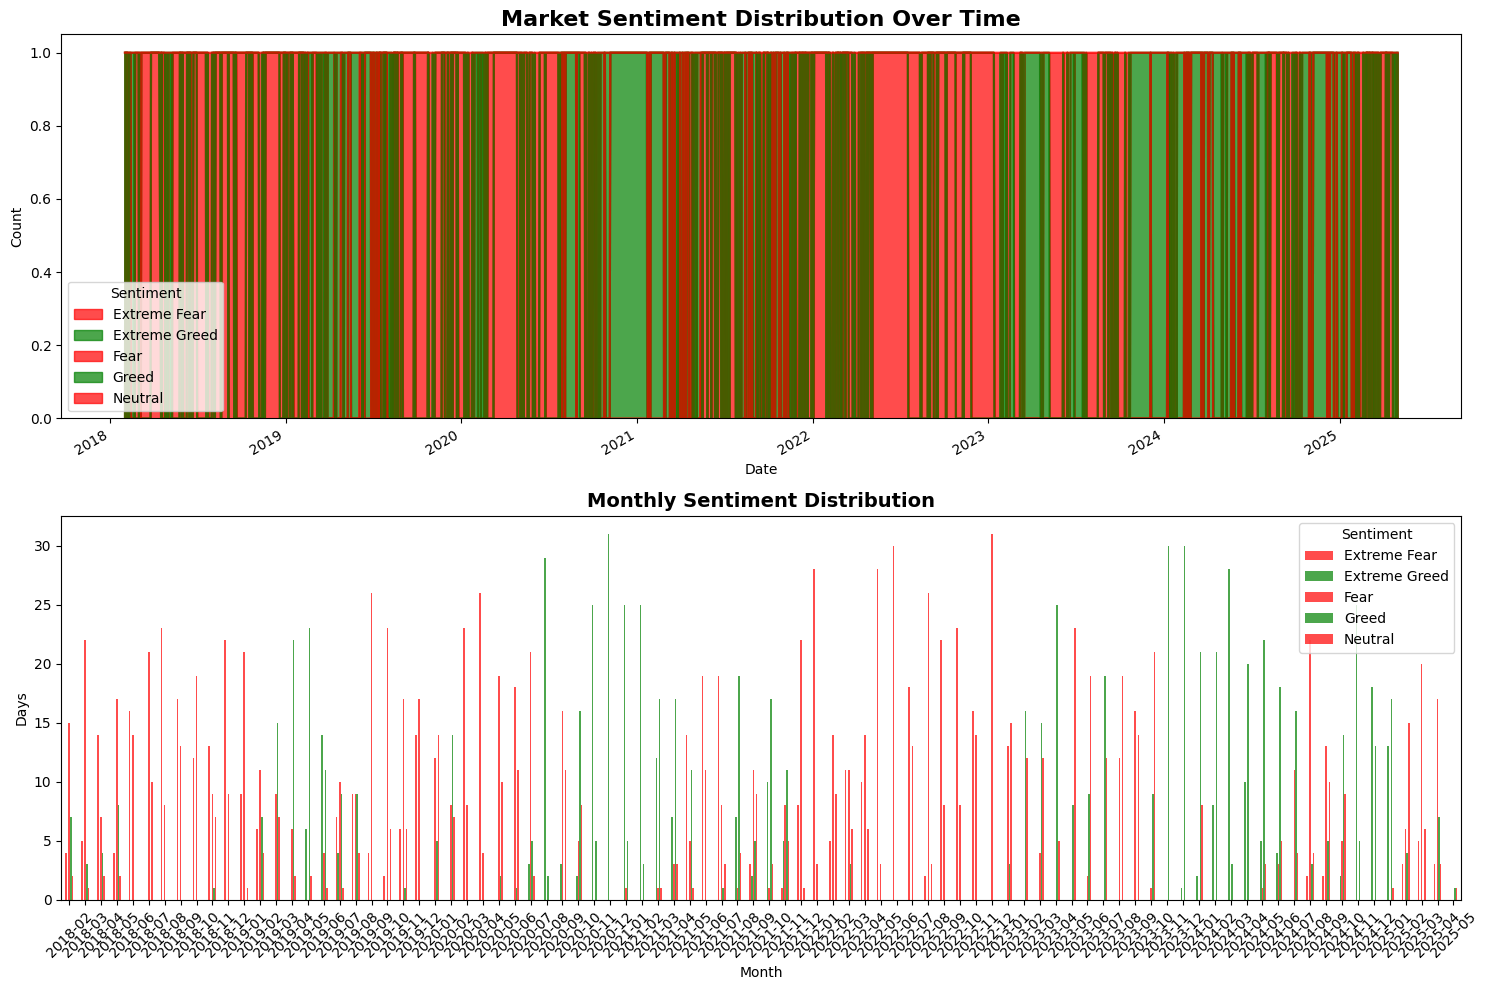

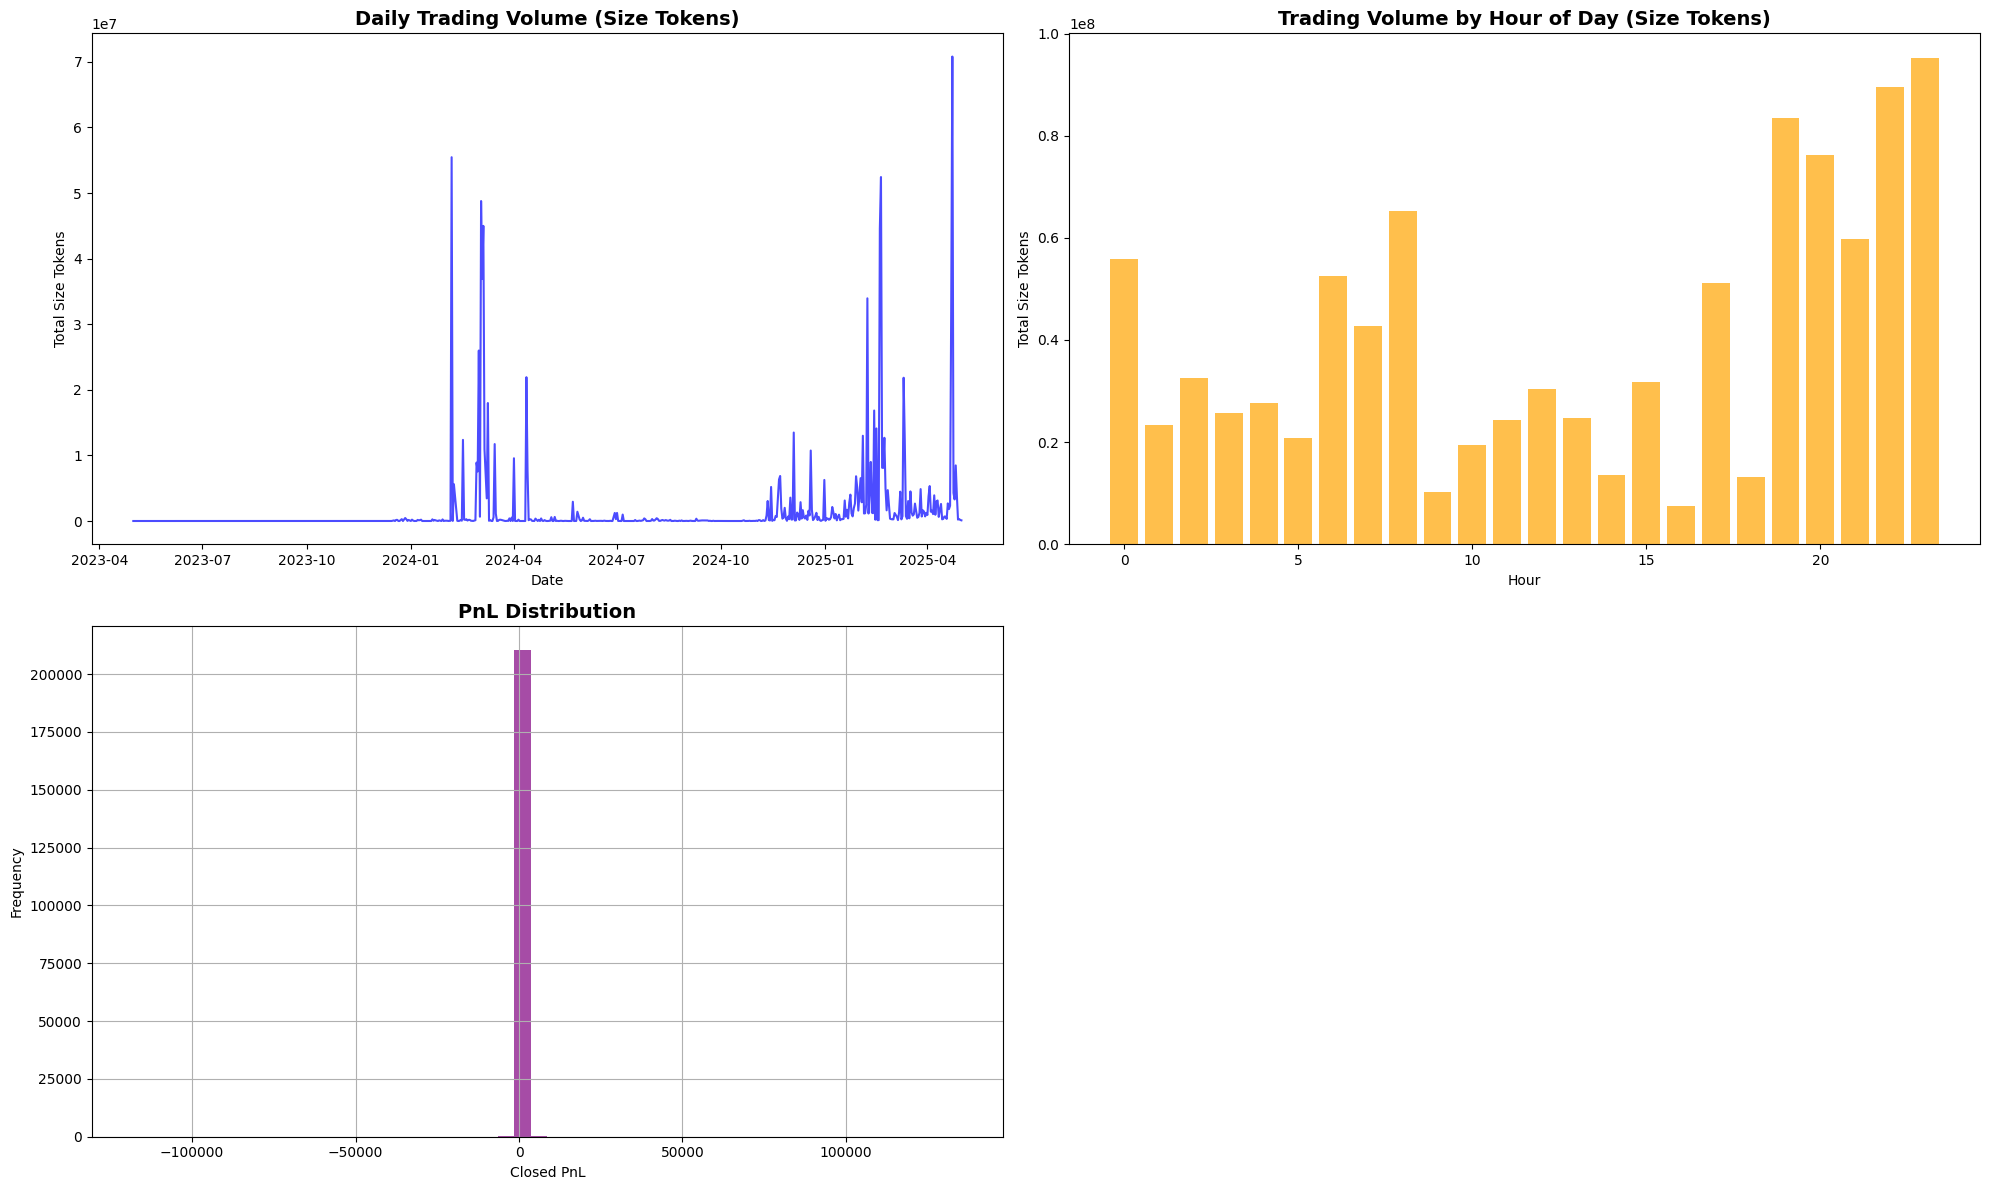


📈 SUMMARY STATISTICS
------------------------------
Market Sentiment Distribution (%):
  Fear: 29.5%
  Greed: 23.9%
  Extreme Fear: 19.2%
  Neutral: 15.0%
  Extreme Greed: 12.3%

Trading Summary:
  Total trades: 211,224
  Unique traders: 32
  Average trade size (Tokens): 4623.3650
  Average PnL: $48.75
  Win rate: 41.1% (86,869/211,224)


In [20]:
print("\n📊 EXPLORATORY DATA ANALYSIS")
print("-" * 30)

# Create output directory for plots
os.makedirs('/content/outputs', exist_ok=True)

# 1. Market Sentiment Distribution Over Time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Sentiment over time
sentiment_counts = sentiment_df.groupby(['date', 'classification']).size().unstack(fill_value=0)
sentiment_counts.plot(kind='area', ax=ax1, alpha=0.7, color=['red', 'green'])
ax1.set_title('Market Sentiment Distribution Over Time', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.legend(title='Sentiment')

# Monthly sentiment distribution
sentiment_df['Month'] = sentiment_df['date'].dt.to_period('M')
monthly_sentiment = sentiment_df.groupby(['Month', 'classification']).size().unstack(fill_value=0)
monthly_sentiment.plot(kind='bar', ax=ax2, color=['red', 'green'], alpha=0.7)
ax2.set_title('Monthly Sentiment Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Days')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Sentiment')

plt.tight_layout()
plt.savefig('/content/outputs/sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Trading Volume Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Daily trading volume
daily_volume = trader_df.groupby('date').agg({
    'Size Tokens': 'sum',
    'position_value': 'sum',
    'Account': 'nunique'
}).reset_index()

ax1.plot(daily_volume['date'], daily_volume['Size Tokens'], color='blue', alpha=0.7)
ax1.set_title('Daily Trading Volume (Size Tokens)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Size Tokens')

# Trading by hour
hourly_trading = trader_df.groupby('hour')['Size Tokens'].sum()
ax2.bar(hourly_trading.index, hourly_trading.values, color='orange', alpha=0.7)
ax2.set_title('Trading Volume by Hour of Day (Size Tokens)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Total Size Tokens')

# PnL distribution
trader_df['Closed PnL'].hist(bins=50, ax=ax3, color='purple', alpha=0.7)
ax3.set_title('PnL Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Closed PnL')
ax3.set_ylabel('Frequency')

# Remove leverage distribution as the column is not present
fig.delaxes(ax4)


plt.tight_layout()
plt.savefig('/content/outputs/trading_volume_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Create summary statistics
print("\n📈 SUMMARY STATISTICS")
print("-" * 30)

# Sentiment summary
sentiment_summary = sentiment_df['classification'].value_counts(normalize=True) * 100
print("Market Sentiment Distribution (%):")
for sentiment, pct in sentiment_summary.items():
    print(f"  {sentiment}: {pct:.1f}%")

# Trading summary
print(f"\nTrading Summary:")
print(f"  Total trades: {len(trader_df):,}")
print(f"  Unique traders: {trader_df['Account'].nunique():,}")
print(f"  Average trade size (Tokens): {trader_df['Size Tokens'].mean():.4f}")
print(f"  Average PnL: ${trader_df['Closed PnL'].mean():.2f}")
# Remove average leverage from summary
# print(f"  Average leverage: {trader_df['leverage'].mean():.2f}x")

# Profitability analysis
profitable_trades = (trader_df['Closed PnL'] > 0).sum()
total_trades = len(trader_df)
win_rate = (profitable_trades / total_trades) * 100
print(f"  Win rate: {win_rate:.1f}% ({profitable_trades:,}/{total_trades:,})")

DATA MERGING

In [21]:
print("\n🔗 DATA MERGING")
print("-" * 30)

# Merge datasets on date
merged_df = trader_df.merge(sentiment_df, on='date', how='inner')
print(f"✅ Merged dataset created: {merged_df.shape}")
print(f"Date range: {merged_df['date'].min()} to {merged_df['date'].max()}")

# Check merge success
overlap_days = merged_df['date'].nunique()
total_sentiment_days = sentiment_df['date'].nunique()
total_trader_days = trader_df['date'].nunique()

print(f"\nMerge Statistics:")
print(f"  Overlapping days: {overlap_days}")
print(f"  Sentiment data days: {total_sentiment_days}")
print(f"  Trader data days: {total_trader_days}")
print(f"  Coverage: {(overlap_days/min(total_sentiment_days, total_trader_days)*100):.1f}%")

# Save processed data
merged_df.to_csv('/content/outputs/processed_data.csv', index=False)
print(f"✅ Processed data saved to: /content/outputs/processed_data.csv")


🔗 DATA MERGING
------------------------------
✅ Merged dataset created: (211218, 26)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00

Merge Statistics:
  Overlapping days: 479
  Sentiment data days: 2644
  Trader data days: 480
  Coverage: 99.8%
✅ Processed data saved to: /content/outputs/processed_data.csv


In [22]:
print("\n🔍 INITIAL CORRELATION ANALYSIS")
print("-" * 30)

# Create binary sentiment encoding
merged_df['sentiment_numeric'] = (merged_df['classification'] == 'Greed').astype(int)

# Group by sentiment and calculate key metrics
sentiment_analysis = merged_df.groupby('classification').agg({
    'Closed PnL': ['mean', 'median', 'std'],
    'Size Tokens': ['mean', 'median'],
    'position_value': ['mean', 'median']
}).round(4)

print("Trading Metrics by Sentiment:")
print(sentiment_analysis)

# Statistical significance test
fear_pnl = merged_df[merged_df['classification'] == 'Fear']['Closed PnL']
greed_pnl = merged_df[merged_df['classification'] == 'Greed']['Closed PnL']

if len(fear_pnl) > 0 and len(greed_pnl) > 0:
    t_stat, p_value = stats.ttest_ind(fear_pnl, greed_pnl)
    print(f"\nT-test for PnL difference between Fear and Greed:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  ✅ Statistically significant difference found!")
    else:
        print("  ❌ No statistically significant difference")

# ==============================================================================
# PRELIMINARY INSIGHTS
# ==============================================================================

print("\n💡 PRELIMINARY INSIGHTS")
print("-" * 30)

# Calculate key insights
fear_trades = merged_df[merged_df['classification'] == 'Fear']
greed_trades = merged_df[merged_df['classification'] == 'Greed']

if len(fear_trades) > 0 and len(greed_trades) > 0:
    insights = {
        'fear_avg_pnl': fear_trades['Closed PnL'].mean(),
        'greed_avg_pnl': greed_trades['Closed PnL'].mean(),
        'fear_win_rate': (fear_trades['Closed PnL'] > 0).mean() * 100,
        'greed_win_rate': (greed_trades['Closed PnL'] > 0).mean() * 100
    }

    print("Key Findings:")
    print(f"  Fear periods - Avg PnL: ${insights['fear_avg_pnl']:.2f}, Win Rate: {insights['fear_win_rate']:.1f}%")
    print(f"  Greed periods - Avg PnL: ${insights['greed_avg_pnl']:.2f}, Win Rate: {insights['greed_win_rate']:.1f}%")

    # Identify potential patterns
    if insights['fear_avg_pnl'] > insights['greed_avg_pnl']:
        print("\n🔍 Pattern detected: Better performance during FEAR periods (contrarian indicator?)")
    else:
        print("\n🔍 Pattern detected: Better performance during GREED periods (momentum following?)")


🔍 INITIAL CORRELATION ANALYSIS
------------------------------
Trading Metrics by Sentiment:
               Closed PnL                  Size Tokens         position_value  \
                     mean median       std        mean  median           mean   
classification                                                                  
Extreme Fear      34.5379 0.0000 1136.0561   1675.8933 37.4400      5349.7318   
Extreme Greed     67.8929 0.0000  766.8283   8832.4157 42.6400      3112.2516   
Fear              54.2904 0.0000  935.3554   2992.6418 30.0100      7816.1099   
Greed             42.7436 0.0000 1116.0284   4715.3278 30.3000      5736.8844   
Neutral           34.3077 0.0000  517.1222   4383.3687 25.0200      4782.7327   

                         
                 median  
classification           
Extreme Fear   766.1500  
Extreme Greed  500.0500  
Fear           735.9600  
Greed          555.0000  
Neutral        547.6550  

T-test for PnL difference between Fear and Greed:

In [23]:
import pandas as pd

# Load the processed data
processed_df = pd.read_csv('/content/outputs/processed_data.csv')

# Display the first few rows to confirm it's loaded correctly
display(processed_df.head())

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,hour,day_of_week,month,position_value,pnl_category,timestamp,value,classification,Month
0,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1898.6000,0.0722,137.0800,BUY,01-05-2023 01:06,0.1791,Open Long,0.0000,0x875d3e1af52b5b758e4f04015b774e0111006a118601...,173271100,True,0.0000,0.0000,2023-05-01 01:06:00,2023-05-01,1,0,5,137.0800,Small Loss,1682919000,63,Greed,2023-05
1,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9000,0.0824,156.3900,BUY,01-05-2023 01:06,0.0967,Open Long,0.0000,0x875d3e1af52b5b758e4f04015b774e0111006a118601...,173271100,True,0.0000,0.0000,2023-05-01 01:06:00,2023-05-01,1,0,5,156.3900,Small Loss,1682919000,63,Greed,2023-05
2,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.9000,0.0967,183.5300,BUY,01-05-2023 01:06,0.0000,Open Long,0.0000,0x875d3e1af52b5b758e4f04015b774e0111006a118601...,173271100,True,0.0000,0.0000,2023-05-01 01:06:00,2023-05-01,1,0,5,183.5300,Small Loss,1682919000,63,Greed,2023-05
3,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1000,0.4933,1100.1100,BUY,05-12-2023 03:11,0.0000,Open Long,0.0000,0x02721e3c6061bddfdc1204065f9dfe0138003649ef8c...,4064960965,True,0.2750,632000000000000.0000,2023-12-05 03:11:00,2023-12-05,3,1,12,1100.1100,Small Loss,1701754200,75,Extreme Greed,2023-12
4,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.1000,0.8681,1935.9500,BUY,05-12-2023 03:11,0.4933,Open Long,0.0000,0x02721e3c6061bddfdc1204065f9dfe0138003649ef8c...,4064960965,True,0.4840,234000000000000.0000,2023-12-05 03:11:00,2023-12-05,3,1,12,1935.9500,Small Loss,1701754200,75,Extreme Greed,2023-12
